In [348]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.metrics import precision_score , recall_score 
import xgboost as xgb 
import pandas as pd 
import sklearn.neighbors._base
from os import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2
sns.set_style('whitegrid')
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [349]:
def details(data_sent , comments = ''):
    if(comments):
        print(comments)
    sp = (data_sent.isna().sum().sum())/ data_sent.size
    print('________________________________________________')
    print('Sparsity in the data : {:.2f}'.format(sp))
    num_rows = data_sent.shape
    print('Data shape' , num_rows)
    #display(data_sent['class'].value_counts())
    print('Number of sources : ')
    cl = data_sent['class'].unique()
    for c in cl:
        num_src = len(data_sent[data_sent['class']==c]['src_id'].unique())
        num_obs = len(data_sent[data_sent['class']==c])
        print(c ,' \t ' , num_src , '\t' , num_obs)

In [350]:
from features import phot_flux , en_flux , hard, powlaw_fit , bb_fit , brems_fit , intra_obs_var , inter_ob_var , info_col , phot_flux_hilim , phot_flux_lolim , en_flux_hilim , en_flux_lolim

In [351]:
info_col_cl =  info_col+['class']

In [352]:
data_imp_v2 = pd.read_csv('imputed_data/new-data-all-at-once-imp.csv' , index_col='obs_id')

In [353]:
details(data_imp_v2)

________________________________________________
Sparsity in the data : 0.00
Data shape (3103, 59)
Number of sources : 
CV  	  184 	 1582
PL  	  178 	 1000
LX  	  58 	 521


In [354]:

df_comb = pd.DataFrame()
for s in data_imp_v2['src_id'].unique()[:]:
    temp = data_imp_v2[data_imp_v2['src_id']==s]
    temp_id =  temp[info_col_cl]
    temp_val = temp.drop(columns=info_col_cl)
    temp_mean = temp_val.mean().to_frame().T
    temp_id_top = temp_id.iloc[0:1].reset_index()
    temp_final = pd.concat([temp_id_top , temp_mean] , axis=1).set_index('obs_id')
    df_comb = df_comb.append(temp_final)
display(df_comb)


,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.600161,0.007931,0.002263,0.002978,0.001218,0.515405,0.523568,5.00,3.07375,5.417707e-04
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.636945,0.004085,0.001735,0.002451,0.000613,0.614881,0.574516,5.00,3.00000,9.789000e-07
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,0.677229,0.004417,0.001721,0.002179,0.000574,0.665955,0.543535,3.00,4.00000,1.081000e-06
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,0.353444,0.004808,0.003408,0.003737,0.000345,0.381742,0.226397,6.00,8.00000,7.858000e-07
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.746582,0.005740,0.002950,0.003574,0.000689,0.606845,0.558287,3.00,4.00000,1.098000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,0.539000,0.003494,0.003420,0.003456,0.000029,0.829000,0.084000,5.11,3.03000,2.125299e-05
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,0.211000,0.003517,0.001060,0.001171,0.000255,0.265000,0.807000,5.00,3.03000,2.151511e-05
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,0.547000,0.002756,0.001488,0.001623,0.000211,0.735000,0.451000,3.00,5.00000,8.482809e-07


In [355]:
data_id = df_comb[info_col]
data_label = df_comb['class']
data_val = df_comb.drop(columns=['class']+info_col)
data_imp_norm = df_comb.copy()
for c in data_val.columns.to_list():
    data_imp_norm.loc[:,c] = (data_imp_norm.loc[:,c] - data_imp_norm.loc[:,c].mean()) / data_imp_norm.loc[:,c].std()
data_imp_norm

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.140383,-0.193753,-0.407606,-0.409996,0.042725,-0.250447,0.492569,0.200236,-0.756434,0.168818
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.300193,-0.422380,-0.452348,-0.450546,-0.153447,0.182504,0.710415,0.200236,-0.795530,-0.096487
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,0.475208,-0.402661,-0.453504,-0.471439,-0.166164,0.404797,0.577944,-0.948770,-0.265416,-0.096436
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,-0.931496,-0.379399,-0.310762,-0.351673,-0.240642,-0.832196,-0.778104,0.774739,1.855039,-0.096581
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.776519,-0.324030,-0.349557,-0.364175,-0.128738,0.147528,0.641022,-0.948770,-0.265416,-0.096428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,-0.125336,-0.457551,-0.309760,-0.373279,-0.343210,1.114425,-1.386978,0.263431,-0.779626,-0.086540
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,-1.550353,-0.456183,-0.509419,-0.548922,-0.269642,-1.340299,1.704492,0.200236,-0.779626,-0.086412
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,-0.090579,-0.501432,-0.473210,-0.514178,-0.283957,0.705305,0.182274,-0.948770,0.264698,-0.096551


In [356]:
details(data_imp_norm)

________________________________________________
Sparsity in the data : 0.00
Data shape (420, 59)
Number of sources : 
CV  	  184 	 184
PL  	  178 	 178
LX  	  58 	 58


## Load 47 Tuc cross matches

In [341]:
xmatch = pd.read_csv('tuc_df_xmatch.csv')
#display(xmatch)
xmatch['tuc_class'].value_counts()

CV             27
MSP            21
Name: tuc_class, dtype: int64

In [100]:
val_obs_id = xmatch['df_obs_if']

In [102]:
from features import drop_corr_feat

In [271]:
flux_feat = ['flux_aper_lolim_m', 'flux_aper_hilim_u', 'flux_aper_lolim_h', 'flux_aper_lolim_s',]
data_imp_non_corr =  data_imp_norm.drop(columns=drop_corr_feat)

In [272]:
from imblearn.over_sampling import SMOTE

In [222]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

  0%|          | 0/1 [00:00<?, ?it/s]

253 0.7291666666666666


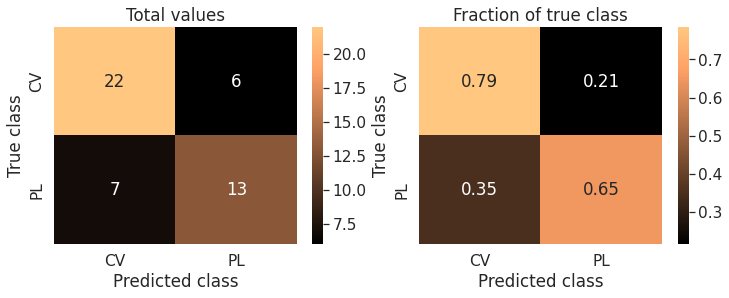

100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


In [321]:
verbose = 0
val_acc = []
test_acc = []
rs = 999
for i in tqdm(range(1)):
    rs = int(np.random.randint(0,99999))
    #rs = 13186
    #rs = 51883
    rs = 253
    np.random.seed(rs)
    class_to_select = ['CV'  ,  'PL']
    df = data_imp_non_corr.copy()
    df = df[df['class'].isin(class_to_select)]
    #display(df)
    val_index =  df.index.isin(val_obs_id)
    df_val =  df[val_index]
    df_train = df[~val_index]
    #details(df_train)
    #details(df_val)
    i_val = df_val[info_col_cl]
    y_val = df_val['class']
    x_val = df_val.drop(columns = info_col_cl)

    i_train = df_train[info_col_cl]
    y_train = df_train['class']
    x_train = df_train.drop(columns = info_col_cl)
    oversample = SMOTE(k_neighbors=10 , n_jobs=-1)
    x_train , y_train = oversample.fit_resample(x_train , y_train)
    clf = RandomForestClassifier(
        n_estimators= 10  , 
        max_depth= 10 , 
        min_samples_split= 3, 
        min_samples_leaf= 1 , 
        #oob_score=True , 
        class_weight={
            'CV': 0.6 , 
            #'LX' : 1,
            'PL' : 2
        } , 
        random_state= 42 
        )
    #clf = DecisionTreeClassifier()
    clf = AdaBoostClassifier(base_estimator=clf , )
    clf.fit(x_train , y_train ,)
    v_sc = clf.score(x_val , y_val)
    print(rs ,  v_sc)
    #break
    '''
    i_val = df[info_col]
    y_val = df['class']
    x_val = df.drop(columns=['class']+info_col)
    x_train , x_test ,i_train, i_test ,  y_train , y_test = train_test_split(x_val , i_val ,y_val , test_size=0.3 , stratify=y_val, )
    clf = RandomForestClassifier(n_estimators=500 , )
    clf.fit(x_train , y_train ,sample_weight=i_train['significance'])
    v_sc = clf.score(x_test , y_test)
    test_sc = clf.score(x_train, y_train)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    #if(verbose):
    '''
    sns.set(font_scale=1.4)
    sns.set_style('whitegrid')
    fig , ax = plt.subplots(nrows=1 , ncols= 2 , figsize = (12 , 4))
    cf = confusion_matrix(y_val , clf.predict(x_val) ,)
    sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[0] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='copper')
    cf = confusion_matrix(y_val , clf.predict(x_val) ,normalize='true')
    sns.heatmap(cf , annot=True ,fmt = '.2f' , ax = ax[1] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='copper')
    ax[0].set_title('Total values')
    ax[1].set_title('Fraction of true class')
    for a in ax:
        a.set_xlabel('Predicted class')
        a.set_ylabel('True class')
    plt.show()
#score

In [325]:
i_val

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class
obs_id,,,,,,,,,,
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.08036,31673.8,20.78,1834.51100,CV
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.07968,5544.8,9.72,548.75650,CV
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.08228,65237.5,25.99,3275.90600,CV
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.08210,31673.8,19.64,2291.21000,CV
CV_6_obs_0,CV_6,13,CXOGlb_J002407.9-720454,2CXO J002407.9-720454,6.033178,-72.08191,68771.4,16.47,1195.21800,CV
CV_7_obs_0,CV_7,13,RX_J0021.8-7221,2CXO J002404.2-720457,6.017843,-72.08276,59044.6,120.12,89709.00000,CV
CV_8_obs_0,CV_8,13,Tuc_1,2CXO J002404.2-720457,6.017843,-72.08276,59044.6,120.12,89709.00000,CV
CV_9_obs_0,CV_9,13,CXOGlb_J002405.6-720504,2CXO J002405.6-720504,6.023684,-72.08451,5307.0,7.44,164.89930,CV
CV_14_obs_0,CV_14,13,CXOGlb_J002403.6-720459,2CXO J002403.7-720459,6.015486,-72.08308,1928.3,12.38,668.74380,CV


In [331]:
pred_prob = clf.predict_proba(x_val)
prob_margin = [abs(p[0]-p[1]) for p in pred_prob]
res_df = pd.DataFrame( pred_prob , columns=['p_cv' , 'p_pl'] , index = i_val.index.to_list())
res_df.insert(0 , 'true_class' , y_val.to_list())
res_df.insert(1 , 'pred_class' , clf.predict(x_val))
res_df.insert(4 , 'prob_margin' , prob_margin)
res_df = res_df.sort_values(by = 'prob_margin')
ind  = [res_df['true_class']==res_df['pred_class']]
res_df.insert(5 , 'truth' , ind[0].to_list())
res_df.insert(6 , 'src_n' , i_val['src_n'].to_list())
res_df

,true_class,pred_class,p_cv,p_pl,prob_margin,truth,src_n
PL_9_obs_0,PL,PL,0.492154,0.507846,0.015692,True,W32
CV_15_obs_0,CV,CV,0.509192,0.490808,0.018383,True,CXOGlb_J002405.2-720446
CV_7_obs_0,CV,CV,0.512142,0.487858,0.024283,True,Cl__NGC_104_MAM_M54898
CV_8_obs_0,CV,CV,0.512142,0.487858,0.024283,True,CXOGlb_J002404.9-720455
CV_9_obs_0,CV,PL,0.484008,0.515992,0.031984,False,CXOGlb_J002407.9-720454
CV_116_obs_0,CV,CV,0.517611,0.482389,0.035221,True,RX_J0021.8-7221
CV_60_obs_0,CV,CV,0.523169,0.476831,0.046338,True,Tuc_1
PL_63_obs_0,PL,PL,0.474384,0.525616,0.051232,True,CXOGlb_J002405.6-720504
PL_34_obs_0,PL,CV,0.527735,0.472265,0.055470,False,CXOGlb_J002403.6-720459
PL_35_obs_0,PL,CV,0.527735,0.472265,0.055470,False,CXOGlb_J002403.1-720447


In [358]:
res_df.to_csv('res_on_47_tuc.csv')

In [336]:
xmatch = xmatch.set_index('df_obs_if')
xmatch.index.name = 'obs_id'
xmatch

,Unnamed: 0,tuc_name,tuc_class,df_name,sep
obs_id,,,,,
CV_114_obs_0,0,CXOGLB J002403.8-720621,CV,2CXO J002403.8-720621,0.218862
CV_116_obs_0,1,CXOGLB J002411.0-720620,CV,2CXO J002411.1-720620,0.181998
CV_61_obs_0,2,CXOGLB J002407.1-720545,CV,2CXO J002407.1-720545,0.125499
CV_60_obs_0,3,CXOGLB J002409.2-720543,CV,2CXO J002409.2-720543,0.109042
CV_48_obs_0,4,CXOGLB J002402.1-720542,CV,2CXO J002402.1-720542,0.156541
PL_74_obs_0,5,CXOGLB J002354.4-720530,MSP,2CXO J002354.5-720530,0.146071
CV_42_obs_0,6,CXOGLB J002407.7-720527,CV,2CXO J002407.7-720527,0.125632
PL_51_obs_0,7,CXOGLB J002411.1-720520,MSP,2CXO J002411.1-720520,0.157085
CV_25_obs_0,8,CXOGLB J002410.6-720516,CV,2CXO J002410.6-720516,0.179185


In [347]:
res_df.sort_values(by = 'prob_margin')

,true_class,pred_class,p_cv,p_pl,prob_margin,truth,src_n
PL_9_obs_0,PL,PL,0.492154,0.507846,0.015692,True,W32
CV_15_obs_0,CV,CV,0.509192,0.490808,0.018383,True,CXOGlb_J002405.2-720446
CV_7_obs_0,CV,CV,0.512142,0.487858,0.024283,True,Cl__NGC_104_MAM_M54898
CV_8_obs_0,CV,CV,0.512142,0.487858,0.024283,True,CXOGlb_J002404.9-720455
CV_9_obs_0,CV,PL,0.484008,0.515992,0.031984,False,CXOGlb_J002407.9-720454
CV_116_obs_0,CV,CV,0.517611,0.482389,0.035221,True,RX_J0021.8-7221
CV_60_obs_0,CV,CV,0.523169,0.476831,0.046338,True,Tuc_1
PL_63_obs_0,PL,PL,0.474384,0.525616,0.051232,True,CXOGlb_J002405.6-720504
PL_34_obs_0,PL,CV,0.527735,0.472265,0.055470,False,CXOGlb_J002403.6-720459
PL_35_obs_0,PL,CV,0.527735,0.472265,0.055470,False,CXOGlb_J002403.1-720447


In [345]:
xmatch_res = pd.concat([res_df , xmatch] , axis=1).sort_values(by='truth')
xmatch_res

,true_class,pred_class,p_cv,p_pl,prob_margin,truth,src_n,Unnamed: 0,tuc_name,tuc_class,df_name,df_obs_if,sep
CV_9_obs_0,CV,PL,0.484008,0.515992,0.031984,False,CXOGlb_J002407.9-720454,NaN,NaN,NaN,NaN,NaN,NaN
PL_86_obs_0,PL,CV,0.764354,0.235646,0.528707,False,B0021-72C,NaN,NaN,NaN,NaN,NaN,NaN
PL_0_obs_0,PL,CV,0.538303,0.461697,0.076606,False,CXOGlb_J002401.4-720441,NaN,NaN,NaN,NaN,NaN,NaN
PL_32_obs_0,PL,CV,0.694443,0.305557,0.388885,False,B0021-72D,NaN,NaN,NaN,NaN,NaN,NaN
PL_33_obs_0,PL,CV,0.694443,0.305557,0.388885,False,B0021-72N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,CXOGLB J002416.4-720425,MSP,2CXO J002416.5-720425,PL_58_obs_0,0.213941
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,CXOGLB J002403.7-720423,CV,2CXO J002403.7-720423,CV_26_obs_0,0.090569
45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,CXOGLB J002406.7-720406,MSP,2CXO J002406.7-720406,PL_59_obs_0,0.061901
46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,CXOGLB J002409.8-720359,MSP,2CXO J002409.8-720359,PL_61_obs_0,0.143639


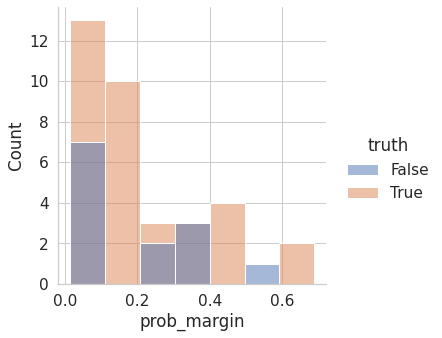

In [327]:
sns.displot(
    data = res_df , 
    x= 'prob_margin' , 
    kind = 'hist', 
    hue = 'truth'
)
plt.show()

In [120]:
x_val.columns

Index(['hard_hm', 'hard_hs', 'hard_ms', 'var_inter_prob_b',
       'var_inter_sigma_m', 'var_inter_sigma_s', 'var_inter_index_b',
       'flux_aper_lolim_m', 'flux_aper_hilim_u', 'flux_aper_lolim_h',
       'var_inter_index_h', 'flux_aper_lolim_s', 'var_mean_b', 'var_sigma_b',
       'ks_prob_b', 'var_prob_b', 'var_inter_index_s', 'var_inter_index_m',
       'var_inter_sigma_u'],
      dtype='object')

In [275]:
verbose = 0
val_acc = []
test_acc = []
rs = 999
for i in tqdm(range(10)):
    rs = int(np.random.randint(0,99999))
    #rs = 39440
    #rs = 57865
    np.random.seed(rs)
    src_list = pd.DataFrame()
    class_to_select = ['CV' , 'LX' , 'PL']
    df = data_imp_non_corr.copy()
    val_index =  df.index.isin(val_obs_id)
    #df =  df[val_index]
    #df = df[~val_index]
    i_val = df[info_col]
    y_val = df['class']
    x_val = df.drop(columns=['class']+info_col)
    x_train , x_test ,i_train, i_test ,  y_train , y_test = train_test_split(x_val , i_val ,y_val , test_size=0.3 , stratify=y_val, )
    clf = RandomForestClassifier(n_estimators=200 , )

    oversample = SMOTE(k_neighbors=10 , n_jobs=-1)
    x_train , y_train = oversample.fit_resample(x_train , y_train)

    clf = RandomForestClassifier(
        n_estimators = 10  , 
        max_depth= 10 , 
        min_samples_split= 3, 
        min_samples_leaf= 1 , 
        #oob_score=True , 
        class_weight={
            'CV': 0.6 , 
            'LX' : 1,
            'PL' : 2
        } , 
        random_state= 42 
        )
    #clf = DecisionTreeClassifier()
    clf = AdaBoostClassifier(base_estimator=clf , )
    clf.fit(x_train , y_train ,)

    clf.fit(x_train , y_train)
    v_sc = clf.score(x_test , y_test)
    test_sc = clf.score(x_train, y_train)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    #if(verbose):
    print(rs ,  v_sc)

 10%|█         | 1/10 [00:03<00:27,  3.01s/it]

98922 0.6666666666666666


 20%|██        | 2/10 [00:05<00:23,  2.93s/it]

86158 0.6984126984126984


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

15444 0.7380952380952381


 40%|████      | 4/10 [00:11<00:16,  2.69s/it]

2157 0.6984126984126984


 50%|█████     | 5/10 [00:13<00:12,  2.57s/it]

988 0.6349206349206349


 60%|██████    | 6/10 [00:15<00:10,  2.52s/it]

15874 0.6349206349206349


 70%|███████   | 7/10 [00:18<00:07,  2.50s/it]

22022 0.6904761904761905


 80%|████████  | 8/10 [00:20<00:04,  2.46s/it]

62099 0.5952380952380952


 90%|█████████ | 9/10 [00:23<00:02,  2.42s/it]

94039 0.6746031746031746


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]

50547 0.8015873015873016


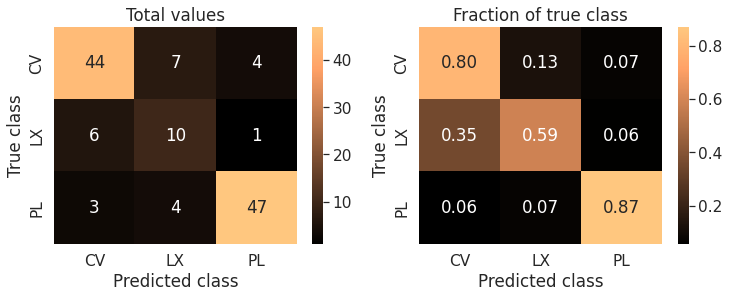

In [276]:
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols= 2 , figsize = (12 , 4))
cf = confusion_matrix(y_test , clf.predict(x_test) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[0] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='copper')
cf = confusion_matrix(y_test , clf.predict(x_test) ,normalize='true')
sns.heatmap(cf , annot=True ,fmt = '.2f' , ax = ax[1] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='copper' )
ax[0].set_title('Total values')
ax[1].set_title('Fraction of true class')
for a in ax:
    a.set_xlabel('Predicted class')
    a.set_ylabel('True class')
plt.show()
#score

In [76]:
i_test

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood
obs_id,,,,,,,,,
PL_83_obs_0,PL_83,6,J2032+4127,2CXO J203213.1+412724,308.054700,41.456740,27885.5,8.11,2.934485e+02
CV_187_obs_0,CV_187,2,CXOGBS_J174426.3-271925,2CXO J174426.3-271925,266.109900,-27.323860,2153.9,4.28,9.179511e+01
PL_123_obs_0,PL_123,4,J1640-4631,2CXO J164043.5-463135,250.181300,-46.526450,39549.0,9.32,4.274196e+02
PL_23_obs_0,PL_23,18,J1748-2446E,2CXO J174804.8-244645,267.020100,-24.779180,84155.4,29.08,1.785981e+03
PL_196_obs_0,PL_196,1,J1852+0158g,2CXO J165338.0-015836,253.408500,-1.976860,20773.0,16.20,1.842555e+03
PL_28_obs_0,PL_28,18,J1748-2446I,2CXO J174804.8-244645,267.020100,-24.779180,84155.4,29.08,1.785981e+03
CV_10_obs_0,CV_10,17,CXOGlb_J174804.0-244640,2CXO J174804.0-244640,267.017100,-24.777960,30499.4,31.92,4.878009e+03
CV_233_obs_0,CV_233,1,Gaia19cyi,2CXO J194129.2+401124,295.371800,40.190100,21686.7,13.60,1.338434e+03
CV_45_obs_0,CV_45,31,V__DK_Cas,2CXO J123046.3+122323,187.693000,12.389800,51552.5,10.29,2.707684e+02


In [77]:
i_val_pl

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class
obs_id,,,,,,,,,,
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.08036,31673.8,20.78,1834.51100,CV
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.07968,5544.8,9.72,548.75650,CV
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.08228,65237.5,25.99,3275.90600,CV
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.08210,31673.8,19.64,2291.21000,CV
CV_6_obs_0,CV_6,13,CXOGlb_J002407.9-720454,2CXO J002407.9-720454,6.033178,-72.08191,68771.4,16.47,1195.21800,CV
CV_7_obs_0,CV_7,13,RX_J0021.8-7221,2CXO J002404.2-720457,6.017843,-72.08276,59044.6,120.12,89709.00000,CV
CV_8_obs_0,CV_8,13,Tuc_1,2CXO J002404.2-720457,6.017843,-72.08276,59044.6,120.12,89709.00000,CV
CV_9_obs_0,CV_9,13,CXOGlb_J002405.6-720504,2CXO J002405.6-720504,6.023684,-72.08451,5307.0,7.44,164.89930,CV
CV_14_obs_0,CV_14,13,CXOGlb_J002403.6-720459,2CXO J002403.7-720459,6.015486,-72.08308,1928.3,12.38,668.74380,CV


In [72]:
df_val

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.08036,31673.8,20.78,1834.51100,CV,...,0.300193,-0.422380,-0.452348,-0.450546,-0.153447,0.182504,0.710415,0.200236,-0.795530,-0.096487
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.07968,5544.8,9.72,548.75650,CV,...,0.475208,-0.402661,-0.453504,-0.471439,-0.166164,0.404797,0.577944,-0.948770,-0.265416,-0.096436
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.08228,65237.5,25.99,3275.90600,CV,...,-0.931496,-0.379399,-0.310762,-0.351673,-0.240642,-0.832196,-0.778104,0.774739,1.855039,-0.096581
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.08210,31673.8,19.64,2291.21000,CV,...,0.776519,-0.324030,-0.349557,-0.364175,-0.128738,0.147528,0.641022,-0.948770,-0.265416,-0.096428
CV_6_obs_0,CV_6,13,CXOGlb_J002407.9-720454,2CXO J002407.9-720454,6.033178,-72.08191,68771.4,16.47,1195.21800,CV,...,0.667280,-0.452350,-0.479469,-0.496770,-0.200178,0.365447,0.826214,-0.948770,-0.795530,-0.096584
CV_7_obs_0,CV_7,13,RX_J0021.8-7221,2CXO J002404.2-720457,6.017843,-72.08276,59044.6,120.12,89709.00000,CV,...,1.435700,6.265786,2.975304,4.253645,5.135212,0.969793,0.478955,1.923745,1.855039,-0.089637
CV_8_obs_0,CV_8,13,Tuc_1,2CXO J002404.2-720457,6.017843,-72.08276,59044.6,120.12,89709.00000,CV,...,1.435700,6.265786,2.975304,4.253645,5.135212,0.969793,0.478955,1.923745,1.855039,-0.089637
CV_9_obs_0,CV_9,13,CXOGlb_J002405.6-720504,2CXO J002405.6-720504,6.023684,-72.08451,5307.0,7.44,164.89930,CV,...,0.485460,-0.255368,-0.477704,-0.481765,0.033704,0.524783,0.940686,0.200236,0.264698,-0.096661
CV_14_obs_0,CV_14,13,CXOGlb_J002403.6-720459,2CXO J002403.7-720459,6.015486,-72.08308,1928.3,12.38,668.74380,CV,...,-0.298336,-0.465342,-0.456011,-0.487008,-0.233567,-0.047024,0.376792,-0.948770,-0.795530,-0.092755


In [360]:
data_imp_v2['hard_hm']

obs_id
CV_0_obs_0       0.9994
CV_0_obs_1       0.9994
CV_0_obs_2       0.9994
CV_0_obs_3       0.9994
CV_0_obs_4      -0.9994
                  ...  
LMXB_86_obs_0   -0.2124
LMXB_90_obs_0    0.2711
LMXB_91_obs_0   -0.6034
LMXB_92_obs_0    0.3310
LMXB_94_obs_0   -0.9994
Name: hard_hm, Length: 3103, dtype: float64

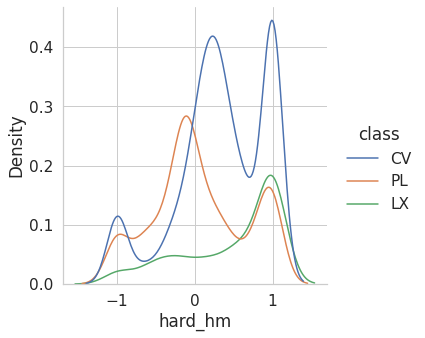

In [362]:
sns.displot(
    data = data_imp_v2 , 
    x = 'hard_hm',
    hue = 'class' , 
    kind = 'kde'
)